# Run training for Pine

In [1]:
import sys
import os
path_to_top_dir = "../"
# Dynamically add the `project` directory to the path
sys.path.append(os.path.abspath(path_to_top_dir))

In [2]:
os.path.abspath(path_to_top_dir)

'c:\\Users\\paulj\\Desktop\\prosjekt\\pom_cpu-model'

In [3]:
# Print current working directory
os.getcwd()

'c:\\Users\\paulj\\Desktop\\prosjekt\\pom_cpu-model\\runs'

In [4]:
# Import scent_gfn functions
from scent_gfn.fragments import FRAGMENTS, FRAGMENTS_OPENPOM_DATASET, FRAGMENTS_OPENPOM_VANILLA
from scent_gfn.molecule import MoleculeTrainer

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading some PyTorch models, missing a dependency. No module named 'tensorflow'
c:\Users\paulj\Desktop\prosjekt\pom_cpu-model\venv\lib\site-packages\deepchem\models\torch_models\torch_model.py:1078: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

| **Parameter**                | **Value**      |
|------------------------------|----------------|
| Reward function type         | OpenPOM        |
| Similarity measure           | Cosine         |
| Graph building               | Fragments      |
| Iterations                   | 500            |
| Max number of nodes          | 6              |
| Illegal action logreward     | -100           |
| β                            | 1              |
| Large molecule penalty       | Hard           |

In [5]:
params = {
    "save_name": "pine2",
    "reward_func": "openpom", # structure, openpom
    "similarity": "cosine",
    "graph_building": FRAGMENTS,#FRAGMENTS,
    "iterations": 500,
    "max_nodes": 6,
    "illegal_logreward": -100,
    "beta": 1.0,
    "large_mol_pen": ["hard", 23] # ["exponential", 15] , ["hard", 15], [None,None]
}

In [6]:
# Utilities
import warnings
import random
import datetime

# Data processing and file management
import pathlib
import pandas as pd
import json
import numpy as np

# Machine learning
import torch
from gflownet.config import init_empty, Config
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage, MolToImage


# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Run on cpu
dev = torch.device('cpu')

In [7]:
def get_pine_openpom_target():
    with open('../data/pine_target_2.json', 'r') as file:
        target = json.load(file)
    return [target]



In [8]:
def get_vanilla_test_and_training(split_ratio=0.7):
    df = pd.read_csv("../data/data.csv")
    vanilla_mols_df = df.loc[df['vanilla'] == 1]
    vanilla_smiles_trainig= list(vanilla_mols_df["nonStereoSMILES"])
    vanilla_smiles_trainig = random.sample(vanilla_smiles_trainig, round(len(vanilla_mols_df)*split_ratio))
    random.shuffle(vanilla_smiles_trainig)
    vanilla_smiles_test = []
    for i in vanilla_mols_df["nonStereoSMILES"]:
        if i not in vanilla_smiles_trainig:
            vanilla_smiles_test.append(i)
    return vanilla_smiles_trainig, vanilla_smiles_test

def get_vanillin():
    return ["COc1cc(C=O)ccc1O"]



In [9]:
target = get_pine_openpom_target() #get_vanillin()

In [10]:

# Initialize model
config = init_empty(Config())
config.print_every = 1
config.log_dir = f"{os.path.abspath(path_to_top_dir)}/results/{params['save_name']}_{datetime.datetime.now().strftime('%Y-%m-%d__%H_%M_%S')}"
config.device = dev
config.num_training_steps = params["iterations"]
config.num_workers = 0
config.num_validation_gen_steps = 1
config.overwrite_existing_exp=False
config.checkpoint_every = 100
config.algo.max_nodes = params["max_nodes"] #12 # 95 quantil
config.store_all_checkpoints = True
config.algo.illegal_action_logreward = params["illegal_logreward"]

if params["graph_building"] == None:
     trial = MoleculeTrainer(config,(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]), print_config=True) #,fragments=FRAGMENTS, print_config=True)
else:
    trial = MoleculeTrainer(config,(params["reward_func"], params["similarity"],params["large_mol_pen"], target, params["beta"]),fragments=params["graph_building"], print_config=True) #,fragments=FRAGMENTS, print_config=True)

OpenPOM input data detected ...
Reward function: reward_function_openpom | Similarity measure: cosine_similarity | exp_penalty: False | max_mol=23
Building molecules using fragments ...


Hyperparameters:

desc: noDesc
log_dir: c:\Users\paulj\Desktop\prosjekt\pom_cpu-model/results/pine2_2024-12-08__20_52_30
device: cpu
seed: 0
validate_every: 1000
checkpoint_every: 100
store_all_checkpoints: true
print_every: 1
start_at_step: 0
num_final_gen_steps: null
num_validation_gen_steps: 1
num_training_steps: 500
num_workers: 0
hostname: null
pickle_mp_messages: false
git_hash: f106cde
overwrite_existing_exp: false
algo:
  method: TB
  num_from_policy: 64
  num_from_dataset: 0
  valid_num_from_policy: 64
  valid_num_from_dataset: 0
  max_len: 128
  max_nodes: 6
  max_edges: 128
  illegal_action_logreward: -100.0
  train_random_action_prob: 0.0
  train_det_after: null
  valid_random_action_prob: 0.0
  sampling_tau: 0.9
  tb:
    bootstrap_own_reward: false
    epsilon: null
    reward_loss_multi

In [11]:
trial.run()

08/12/2024 20:52:31 - INFO - logger - Starting training
08/12/2024 20:52:35 - INFO - logger - iteration 1 : offline_loss:0.00 online_loss:2172.95 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.11 loss:2172.95 n_loss:0.00 tb_loss:2172.95 batch_entropy:23.51 traj_lens:9.55 grad_norm:530.34 grad_norm_clip:70.03 sampled_reward_avg:0.21 train_time:1.16 time_spent:4.76
08/12/2024 20:52:41 - INFO - logger - iteration 2 : offline_loss:0.00 online_loss:2022.28 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_unif:0.00 logZ:-0.15 loss:2022.28 n_loss:0.00 tb_loss:2022.28 batch_entropy:26.40 traj_lens:10.34 grad_norm:471.57 grad_norm_clip:69.56 sampled_reward_avg:0.22 train_time:1.33 time_spent:5.34
08/12/2024 20:52:47 - INFO - logger - iteration 3 : offline_loss:0.00 online_loss:1998.52 reward_loss:0.00 invalid_trajectories:0.00 invalid_logprob:0.00 invalid_losses:0.00 backward_vs_uni

In [12]:
with open(os.path.join(config.log_dir, "params.json"), "w+") as file:
    json.dump(params,file)

with open(os.path.join(config.log_dir, "target.json"), "w+") as file:
    json.dump(target,file)

In [13]:
state = {
    "models_state_dict": [trial.model.state_dict()],
    "cfg": trial.cfg,
    "env_ctx": trial.model.env_ctx,
    #"model": trial.model,
}
if trial.sampling_model is not trial.model:
    state["sampling_model_state_dict"] = [trial.sampling_model.state_dict()]
fn = pathlib.Path(trial.cfg.log_dir) / "model_final_save.pt"
with open(fn, "wb") as fd:
    torch.save(
        state,
        fd,
    )

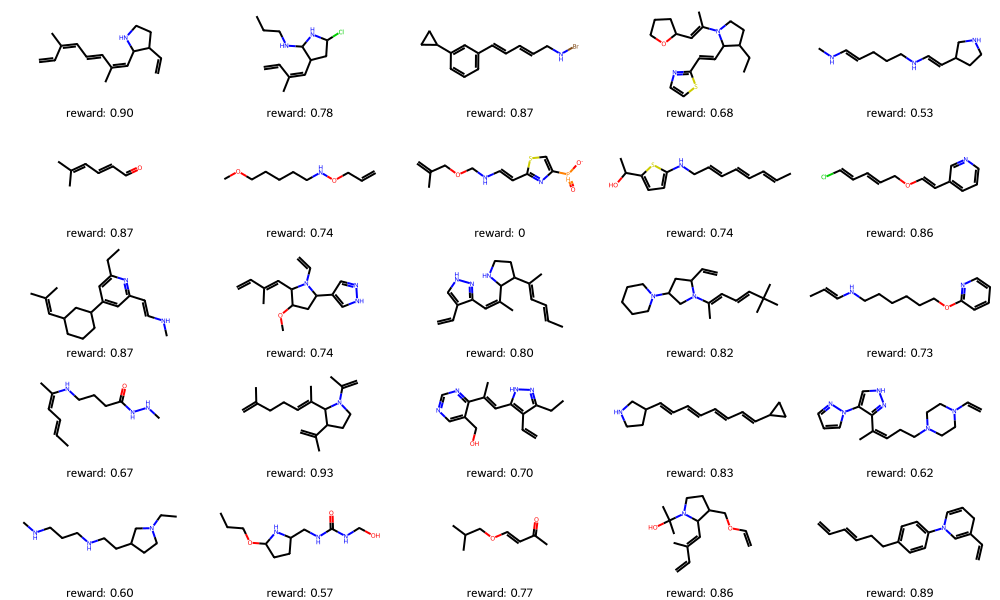

In [15]:
# Generate molecules
trajs = trial.algo.create_training_data_from_own_samples(trial.model, 25)
objs = [trial.ctx.graph_to_obj(i['result']) for i in trajs]
obj_props, is_valid = trial.task.compute_obj_properties(objs)
log_rewards = trial.task.cond_info_to_logreward({'beta': torch.ones(len(obj_props))}, obj_props)
index = 0
rewards = []
for i in is_valid:
    if i:
        rewards.append(list(log_rewards)[index])
        index += 1 
    else:
        rewards.append(0)

MolsToGridImage(objs[:25], molsPerRow=5, subImgSize=(200, 120), legends=[f'reward: {r}' if r==0 else f'reward: {r.exp().item():.2f}' for r in rewards[:25]])

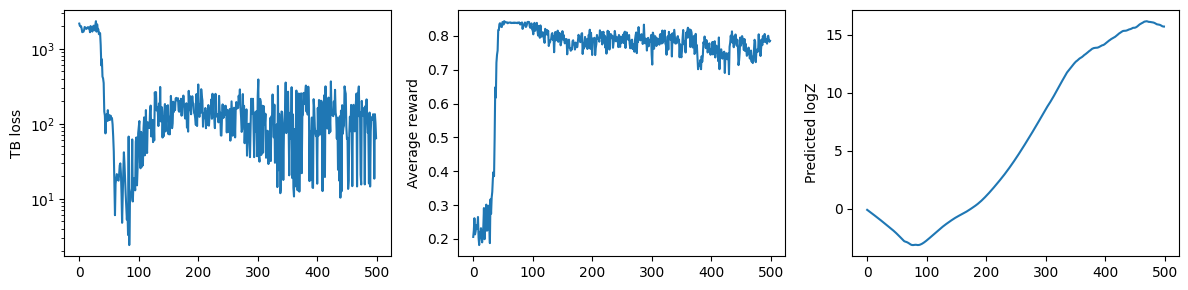

In [16]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')])
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')])
ax[1].set_ylabel('Average reward')
ax[2].plot([i.value for i in ea.Scalars('train_logZ')])
ax[2].set_ylabel('Predicted logZ')
pp.tight_layout()

In [ ]:
tags = ea.Tags()
print("Available tags:", tags)

In [ ]:
from pycirclize import Circos
import pandas as pd
import matplotlib.pyplot as plt
from pom_models.functions import fragance_propabilities_from_smiles
from rdkit import Chem
import numpy as np

In [ ]:
indices = np.argsort(-np.array(target))
indices

In [ ]:
labels = df.keys()[2:]
labels

In [ ]:
data_lst  = []
for i, obj in enumerate(objs):
    smiles = Chem.MolToSmiles(obj)
    probs = fragance_propabilities_from_smiles(smiles)[0]

    data_lst.append( [smiles] + list(probs))
result_df = pd.DataFrame(
    data=data_lst,
    index=[i for i in range(len(data_lst))],
    columns=["smiles"]+list(labels)
    )
result_df.head()


In [ ]:
target_df = pd.DataFrame(
    data=[["target"] + list(target)],
    columns=result_df.keys(),
    index=["Target"]
)
target_df

In [ ]:
most_important_indicies = indices[:8]
most_important_keys = []
for i in most_important_indicies:
    most_important_keys.append(labels[i])
most_important_keys

In [ ]:
rewards_plot = [f'{r}' if r==-1 else f'{r.exp().item():.2f}' for r in rewards[:25]]
rewards_plot

In [ ]:
plot_df = result_df[most_important_keys].set_index(pd.Series([f"{i+1} r:{rewards_plot[i]}" for i in range(len(result_df["smiles"]))]))
plot_df

In [ ]:
plot_target_df = target_df[most_important_keys]
plot_target_df

In [ ]:
plot_df.loc["target"] = []

In [ ]:


# Create 5 x 5 subplots
fig = plt.figure(figsize=(26, 16), dpi=100)
fig.subplots(5, 5, subplot_kw=dict(polar=True))
fig.subplots_adjust(wspace=1, hspace=0.25)

# Plot radar chart into subplots for each target
for target_name, ax in zip(plot_df.index, fig.axes):
    target_df = plot_df.loc[[target_name]]
    target_df = pd.concat([target_df, plot_target_df])
    # Initialize Circos instance for radar chart plot
    circos = Circos.radar_chart(
        target_df,
        vmax=1,
        marker_size=6,
        #cmap=dict(Hero="salmon", Warrior="skyblue", Wizard="lime", Assassin="magenta"),
        grid_interval_ratio=0.2,
        line_kws_handler=lambda _: dict(lw=2, ls="solid"),
        marker_kws_handler=lambda _: dict(marker="D", ec="grey", lw=0.5),
    )

    # Plot figure & set legend on upper right
    circos.plotfig(ax=ax)
    circos.ax.legend(loc="upper right", fontsize=10,bbox_to_anchor=(1.7, 1.1))

In [ ]:
np.array(result_df[labels].sum())/len(result_df[labels])

In [ ]:
import seaborn as sns

In [ ]:
from gflownet.config import init_empty, Config
cfg = init_empty(Config())
from tensorboard.backend.event_processing import event_accumulator
cfg.log_dir = config.log_dir
ea = event_accumulator.EventAccumulator(cfg.log_dir)
ea.Reload()

import matplotlib.pyplot as pp
f, ax = pp.subplots(1, 3, figsize=(4*3,3))
ax[0].plot([i.value for i in ea.Scalars('train_loss')], color=sns.color_palette("Set2")[0],linewidth=1)
ax[0].set_yscale('log')
ax[0].set_ylabel('TB loss')
ax[0].grid()
ax[1].plot([i.value for i in ea.Scalars('train_sampled_reward_avg')], color=sns.color_palette("Set2")[0],linewidth=1)
ax[1].set_ylabel('Average reward')
ax[1].set_xlabel('Iteration')
ax[1].grid()
ax[2].plot([i.value for i in ea.Scalars('train_logZ')], color=sns.color_palette("Set2")[0],linewidth=1)
ax[2].set_ylabel('Predicted logZ')
ax[2].grid()
pp.tight_layout()
plt.savefig("images/pine_run_plots.pdf")